<a href="https://colab.research.google.com/github/Mounish2023/fastaicourse/blob/main/recommendation_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from fastai.vision.all import *
from fastai.collab import *

In [3]:
path = untar_data(URLs.ML_100k)
path.ls()

(#23) [Path('/root/.fastai/data/ml-100k/ua.base'),Path('/root/.fastai/data/ml-100k/u.occupation'),Path('/root/.fastai/data/ml-100k/u4.test'),Path('/root/.fastai/data/ml-100k/mku.sh'),Path('/root/.fastai/data/ml-100k/u3.test'),Path('/root/.fastai/data/ml-100k/u.item'),Path('/root/.fastai/data/ml-100k/u5.test'),Path('/root/.fastai/data/ml-100k/u.user'),Path('/root/.fastai/data/ml-100k/ub.test'),Path('/root/.fastai/data/ml-100k/u.data'),Path('/root/.fastai/data/ml-100k/u3.base'),Path('/root/.fastai/data/ml-100k/ua.test'),Path('/root/.fastai/data/ml-100k/u.genre'),Path('/root/.fastai/data/ml-100k/u2.test'),Path('/root/.fastai/data/ml-100k/u1.base'),Path('/root/.fastai/data/ml-100k/u1.test'),Path('/root/.fastai/data/ml-100k/README'),Path('/root/.fastai/data/ml-100k/u5.base'),Path('/root/.fastai/data/ml-100k/ub.base'),Path('/root/.fastai/data/ml-100k/u.info')...]

In [4]:
import pandas as pd

ratings = pd.read_csv(path/'/root/.fastai/data/ml-100k/u.data', delimiter='\t', header=None, names=['user', 'movie','rating', 'timestamp'] )
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
movies = pd.read_csv(path/'/root/.fastai/data/ml-100k/u.item', delimiter='|', encoding='latin-1', usecols=(0,1), names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [7]:

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [46]:
dls.show_batch()

,user,title,rating
0,246,Scream 2 (1997),5
1,860,To Gillian on Her 37th Birthday (1996),2
2,806,"Silence of the Lambs, The (1991)",4
3,456,"Mask, The (1994)",1
4,927,"Sword in the Stone, The (1963)",3
5,892,"Good, The Bad and The Ugly, The (1966)",4
6,59,Somewhere in Time (1980),3
7,506,Sabrina (1995),4
8,97,"Maltese Falcon, The (1941)",3
9,328,"Great Escape, The (1963)",5


In [47]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors =5
n_users, n_movies

(944, 1665)

In [48]:
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [49]:
user_factors[3]

tensor([-0.3897,  0.4143, -0.3808,  0.5874,  0.4012])

# Embeddings

In [50]:
user_factorsv1 = Embedding(n_users,n_factors)
user_factorsv1.num_embeddings, user_factorsv1.embedding_dim

(944, 5)

In [51]:
type(user_factorsv1)

fastai.layers.Embedding

In [52]:
user_factorsv1(torch.tensor([0,1,2]))

tensor([[-0.0080,  0.0034, -0.0021, -0.0050, -0.0146],
        [ 0.0092,  0.0045, -0.0049,  0.0060,  0.0118],
        [ 0.0122,  0.0194,  0.0015,  0.0136, -0.0030]],
       grad_fn=<EmbeddingBackward0>)

In [53]:
nn.Embedding??

In [54]:
(user_factors[0] * movie_factors[0]).sum()

tensor(-3.5656)

In [55]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)

  def forward(self,x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return (users * movies).sum(dim=1)


In [56]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [57]:
x[0], y[0]

(tensor([ 521, 1236]), tensor([3], dtype=torch.int8))

In [62]:
x[:,1]
# user_factorsv1(x[:,1])

tensor([1236, 1214,   33,  274,  563, 1508,  965,  539, 1021,  555,  145,  391,
         340,  232,  390,   16,  356, 1395, 1235,  522,  144, 1179,  954,  554,
         671,  552, 1446,  357, 1049,  868,   71,  572, 1285,  868,  972, 1402,
         123, 1370,  414,   95,  659, 1634,  294, 1267,  208,  518, 1147,  426,
        1399,  210,  641,  576,  374,  821,  145, 1491, 1548, 1168,  161, 1615,
        1442,  379, 1285, 1242])

In [64]:
user_factorsv1(x[:,0])

tensor([[-1.1920e-02,  1.7056e-03,  8.2277e-03, -2.2424e-03,  8.4533e-03],
        [ 9.1971e-03,  1.2435e-02,  9.6006e-03,  1.1490e-02,  4.4579e-03],
        [-3.5388e-03,  6.2981e-03,  8.5360e-03, -7.4079e-03,  1.2153e-02],
        [-2.6485e-03, -5.4518e-04, -1.2076e-02,  1.7148e-03,  4.4914e-03],
        [-1.0340e-02, -3.4101e-03,  7.1289e-03,  1.4786e-02,  4.5247e-04],
        [ 1.2134e-02, -9.8824e-03, -7.0613e-03,  1.3618e-02,  7.0954e-04],
        [ 9.9328e-03, -1.9710e-03, -4.8678e-03, -2.5400e-04, -1.6673e-03],
        [ 1.2746e-02,  1.9628e-02, -1.0303e-02, -6.7295e-03, -3.2637e-03],
        [ 7.2065e-03, -1.4914e-02,  7.5786e-04, -2.9763e-03, -1.8711e-03],
        [ 1.2252e-03,  7.3184e-03, -1.4985e-03, -9.4788e-03,  5.4261e-03],
        [ 1.2518e-02,  6.1463e-03, -1.3385e-02, -1.0754e-03,  8.4864e-03],
        [-6.8276e-04,  4.4144e-03,  1.2980e-02,  9.3408e-03,  6.2183e-03],
        [-6.3748e-03, -8.3633e-03, -1.3131e-02,  1.9343e-02,  4.8582e-03],
        [ 9.1971e-03,  1.

In [58]:
model = DotProduct(n_users,n_movies, n_factors)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [59]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,4.521017,3.891441,00:08
1,1.101123,1.146032,00:08
2,0.958813,1.014809,00:08
3,0.905647,0.983424,00:08
4,0.926116,0.974028,00:08


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

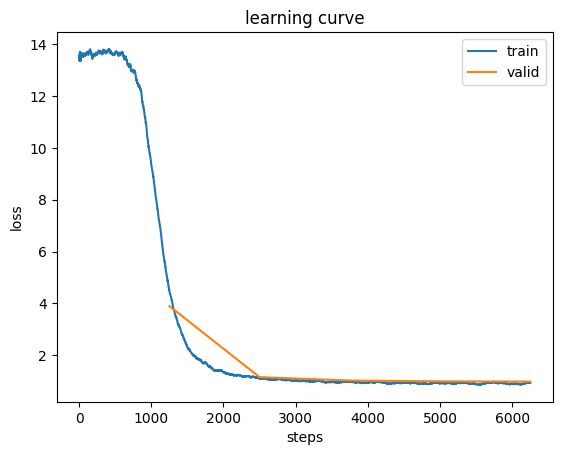

In [60]:
learn.recorder.plot_loss()

In [65]:
class DotProductV1(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.y_range = y_range

  def forward(self,x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])

    return sigmoid_range((users * movies).sum(dim=1), self.y_range[0], self.y_range[1])


In [66]:
y_range = [0,5.5]
modelv1 = DotProductV1(n_users,n_movies,n_factors, y_range)
learnv1 = Learner(dls, modelv1, loss_func=MSELossFlat() )


In [67]:
learnv1.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,1.055613,1.063061,00:08
1,0.919726,0.975103,00:09
2,0.870901,0.956406,00:09
3,0.877590,0.943373,00:08
4,0.856716,0.938637,00:08


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

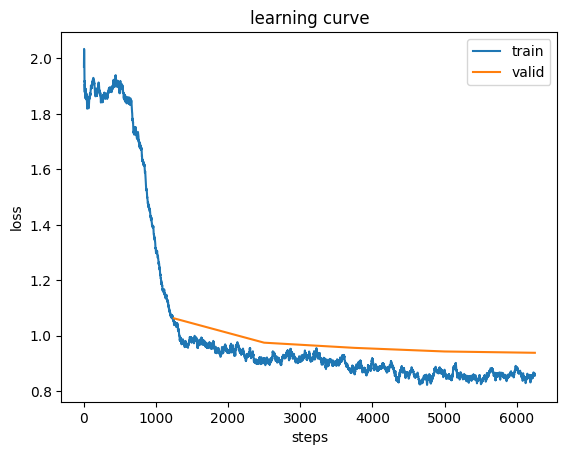

In [69]:
learnv1.recorder.plot_loss()

In [71]:
n_users,n_movies, n_factors

(944, 1665, 5)

In [72]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.user_bias = Embedding(n_users,1)
    self.movie_bias = Embedding(n_movies,1)
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])

    res = (users * movies).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
    return sigmoid_range(res, *self.y_range)


In [80]:
model_with_bias = DotProductBias(n_users,n_movies,50)
learn_with_bias = Learner(dls, model_with_bias, loss_func=MSELossFlat())


In [81]:
learn_with_bias.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.869249,0.953607,00:11
1,0.577503,0.921561,00:11
2,0.414827,0.949514,00:11
3,0.308618,0.962116,00:11
4,0.297596,0.960732,00:11


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

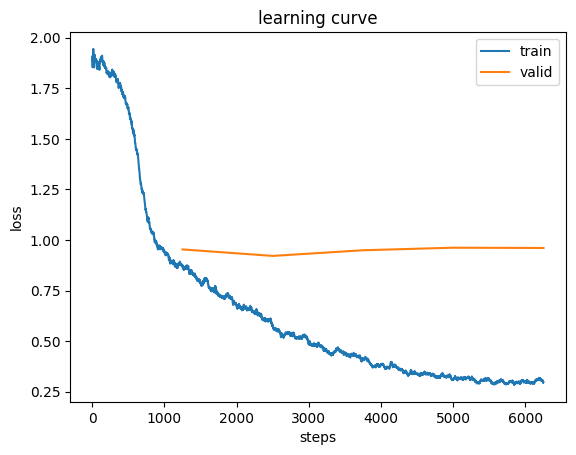

In [82]:
learn_with_bias.recorder.plot_loss()

In [85]:
model_wd = DotProductBias(n_users,n_movies, 50)
learn_wd = Learner(dls, model_wd, loss_func=MSELossFlat())


In [86]:
learn_wd.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.879585,0.959476,00:11
1,0.659221,0.898781,00:11
2,0.520448,0.886606,00:11
3,0.462597,0.863386,00:11
4,0.427271,0.859359,00:11


# Parameters (nn.Parameters)

In [88]:
#Example

class T(Module):
  def __init__(self):
    self.a = torch.tensor([1,2,3])

t = T()
L(t.parameters())

(#0) []

In [89]:
#Example

class T(Module):
  def __init__(self):
    self.a = nn.Parameter(torch.ones(3))

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [102]:
def create_parameters(size):
  return nn.Parameter(torch.zeros(*size).normal_(0,0.01))


class DotProductBiasP(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = create_parameters([n_users,n_factors])
    self.movie_factors = create_parameters([n_movies, n_factors])
    self.user_bias = create_parameters([n_users,1])
    self.movie_bias = create_parameters([n_movies,1])
    self.y_range = y_range
  def forward(self, x):
    users = self.user_factors[x[:,0]]
    movies = self.movie_factors[x[:,1]]
    res = (users * movies).sum(dim=1, keepdim=True)
    res +=   self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]

    return sigmoid_range(res, *self.y_range)



In [103]:
model_p = DotProductBiasP(n_users, n_movies, 50)
learn_p = Learner(dls, model_p, loss_func=MSELossFlat())



In [104]:
learn_p.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.888827,0.959042,00:11
1,0.671067,0.896762,00:11
2,0.522727,0.884619,00:11
3,0.432022,0.870191,00:10
4,0.436399,0.866752,00:11


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

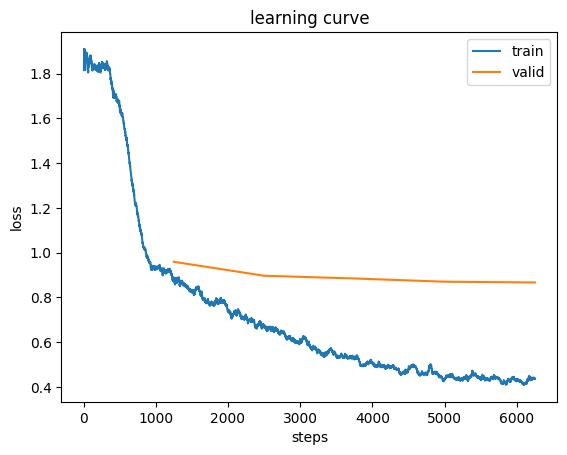

In [105]:
learn_p.recorder.plot_loss()

In [110]:
learn_p.model.movie_bias.shape, learn_p.model.user_bias.shape

(torch.Size([1665, 1]), torch.Size([944, 1]))

In [111]:
movie_bias = learn_p.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[ dls.classes['title'][id] for id in idxs]

['Children of the Corn: The Gathering (1996)',
 'Island of Dr. Moreau, The (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Amityville II: The Possession (1982)',
 'Crow: City of Angels, The (1996)']

In [112]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][id] for id in idxs]

['Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'Titanic (1997)',
 'Good Will Hunting (1997)',
 'L.A. Confidential (1997)']

# using fastai.collab

In [113]:
learn_o = collab_learner(dls, n_factors=50, y_range=(0,5.5))
learn_o.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.849016,0.957276,00:11
1,0.673227,0.899611,00:11
2,0.534502,0.887887,00:11
3,0.454532,0.869400,00:11
4,0.439361,0.865647,00:10


In [114]:
learn_o.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [119]:
movie_bias_o = learn_o.model.i_bias.weight.squeeze()
idxs_o = movie_bias_o.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs_o]

["Schindler's List (1993)",
 'Silence of the Lambs, The (1991)',
 'Shawshank Redemption, The (1994)',
 'Star Wars (1977)',
 'L.A. Confidential (1997)']

In [120]:

len(movie_bias_o)

1665